In [1]:
import os
import cv2
import tensorflow as tf
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import ntpath
import random

%matplotlib inline

### IMPORT DATASET

In [2]:
training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


### CREATING A GRID OF THE DATASET

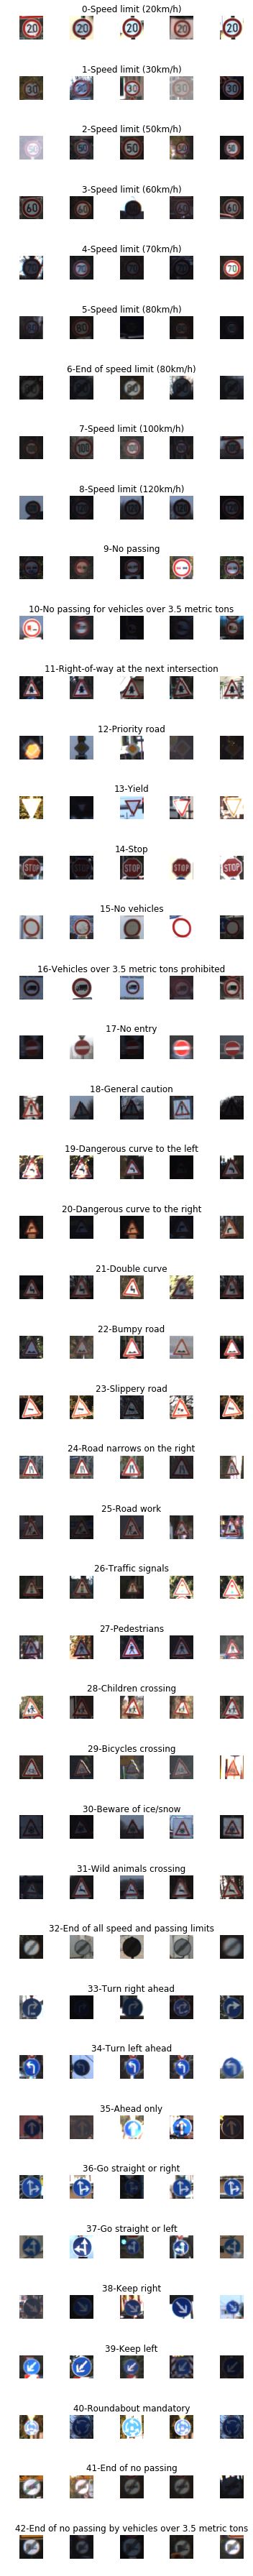

In [4]:
data = pd.read_csv("dataset/signnames.csv")
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))
            
    #(index, Series)

### PLT DISTRIBUTION OF THE TRAIN DATASET

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


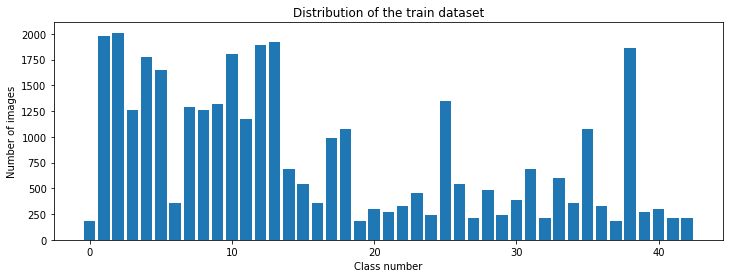

In [5]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


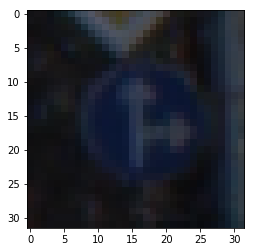

In [6]:
original_image = X_train[1000]
plt.imshow(original_image)
print(X_train[1000].shape)
print(y_train[1000])

### CONVERT COLOR MAP

(32, 32)


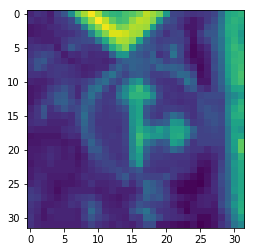

In [7]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
print(img.shape)

### EQUILIZEHIST

(32, 32)


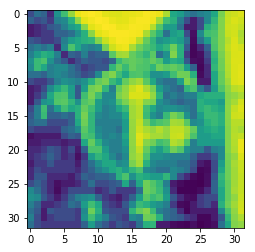

In [8]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
print(img.shape)

### PREPROCESS

In [9]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

In [10]:
X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

In [11]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [12]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### DEFINE A MODEL ARC

In [13]:
EPOCHS = 50
BATCH_SIZE = 20

In [14]:
def conv2d(x, kernel, Input, Output, mu = 0, sigma = 0.1):
    """ 
    return the convolution 
    """
    
    shape = (kernel, kernel, Input, Output)
    conv_W = tf.Variable(tf.truncated_normal(shape=shape, mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(Output))
    conv = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    conv = tf.nn.bias_add(conv, conv_b)
    return conv

In [15]:
def maxPool(conv, pool_size):
    """ 
    return the pool 
    """
    
    pool = tf.nn.max_pool(conv, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='VALID')
    return pool

In [16]:
def fully(fc_i, Input, Output, mu = 0, sigma = 0.1):
    """ 
    return the fully convolutional networks 
    """
    
    shape = (Input, Output)
    fc_W = tf.Variable(tf.truncated_normal(shape=shape, mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(Output))
    fc   = tf.matmul(fc_i, fc_W) + fc_b
    return fc

In [17]:
from tensorflow.contrib.layers import flatten

def trafficNet(x):
    
    # 3x3 convolution with ReLU activation
    conv1 = conv2d(x, 3, 1, 12)
    conv1 = tf.nn.relu(conv1)
    
    # 3x3 convolution with ReLU activation
    conv1 = conv2d(conv1, 3, 12, 24)
    conv1 = tf.nn.relu(conv1)
    pool1 = maxPool(conv1, 2)

    # 5x5 convolution with ReLU activation
    conv2 = conv2d(pool1, 5, 24, 36)
    conv2 = tf.nn.relu(conv2)
    
    # 5x5 convolution with ReLU activation
    conv2 = conv2d(conv2, 5, 36, 48)
    conv2 = tf.nn.relu(conv2)
    pool2 = maxPool(conv2, 2)

    # Flatten
    fc0   = flatten(conv2)
    
    # Dropout
    fc0 = tf.nn.dropout(fc0, 1)
    
    # First Fully
    fc1 = fully(fc0, 1728, 512)
    fc1 = tf.nn.relu(fc1)

    # Second Fully
    fc2 = fully(fc1, 512, 256)
    fc2 = tf.nn.relu(fc2)

    # Output layer
    logits = fully(fc2, 256, num_classes)
    
    return logits, conv1, conv2

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, num_classes)

In [19]:
logits, conv1, conv2 = trafficNet(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
rate = 0.001
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### TRAINING

In [22]:
stopped_at = 5
best_epoch = 0
best_val_acc = 0
history = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print()
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        history.append([train_accuracy, validation_accuracy])
#         saver.save(sess, './model/model')
#         print("Model saved")
        if validation_accuracy > best_val_acc:
            best_epoch, best_val_acc = i, validation_accuracy
            saver.save(sess, './model/model')
            print("Model saved")
        else:
            if i - best_epoch == stopped_at:
                print()
                print('Stopping after {} epochs without improvement'.format(stopped_at))
                break

Training...

EPOCH 1 ...
Training Accuracy = 0.981
Validation Accuracy = 0.953

Model saved

EPOCH 2 ...
Training Accuracy = 0.984
Validation Accuracy = 0.953

Model saved

EPOCH 3 ...
Training Accuracy = 0.973
Validation Accuracy = 0.922


EPOCH 4 ...
Training Accuracy = 0.993
Validation Accuracy = 0.962

Model saved

EPOCH 5 ...
Training Accuracy = 0.987
Validation Accuracy = 0.956


EPOCH 6 ...
Training Accuracy = 0.993
Validation Accuracy = 0.959


EPOCH 7 ...
Training Accuracy = 0.988
Validation Accuracy = 0.952


EPOCH 8 ...
Training Accuracy = 0.994
Validation Accuracy = 0.956


EPOCH 9 ...
Training Accuracy = 0.972
Validation Accuracy = 0.916


Stopping after 5 epochs without improvement


In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    test_accuracy = evaluate(X_test, y_test)
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Test Accuracy = {:.3f} %".format(test_accuracy * 100))
    print("Train Accuracy = {:.3f} %".format(train_accuracy * 100))
    print("Valid Accuracy = {:.3f} %".format(valid_accuracy * 100))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/model
Test Accuracy = 94.442 %
Train Accuracy = 99.348 %
Valid Accuracy = 96.213 %


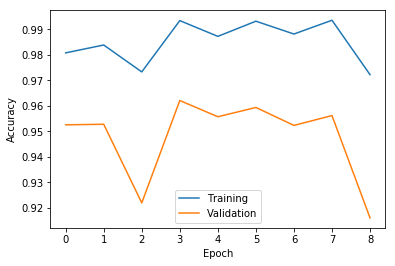

In [24]:
def plot_history(history):
    plt.plot(history)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

plot_history(history)

In [25]:
def localPic():
        
#     pic = './examples/pic1.jpg'       #30km/h
#     pic = './examples/pic2.jpg'       #no entry
    pic = './examples/pic3.jpg'       #yiel
#     pic = './examples/pic4.jpg'       #bicycles crossing
#     pic = './examples/pic5.jpg'       #turn left ahead
#     pic = './examples/pic6.jpg'       #turn right
#     pic = './examples/pic7.jpg'       #80km/h
#     pic = './examples/pic8.jpg'       #no passing 3.5t
#     pic = './examples/pic9.jpg'       #70km/h
#     pic = './examples/pic10.jpg'      #no passing
#     image = mpimg.imread(pic)
    return image

In [26]:
import requests
from PIL import Image

def netPic():
#     url = "http://media.gettyimages.com/photos/traffic-sign-bicycling-prohibited-germany-picture-id486920319?s=170667a&w=1007"
#     url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
    url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"

    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    return img

In [27]:
def testing():
    return localPic() # LOCAL PIC
#     return netPic() # INTERNET PIC

### TOP FIVE SOFTMAX PROBABILITIES AND PREDICTION 

In [28]:
#Preprocess image
def preprocess(img, check):
    print(check)
    if check==True:
        img = np.asarray(img)
        img = cv2.resize(img, (32, 32))
        img = preprocessing(img)
        return img
    if check==False:
        img = testing()
        img = np.asarray(img)
        img = cv2.resize(img, (32, 32))
        img = preprocessing(img)
        return img

In [29]:
### print out the top five softmax probabilities for the predictions
def topFiveSoftmax(output, maxes):
    
    with tf.Session() as sess:
        tops = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(output)),k=5)) 
        indices       = []
        values        = []
        res_append    = []
            
        for i in tops.indices[0].tolist():
            num = tops.indices[0].tolist().index(i)+1
            for j, cnt in zip(maxes,range(len(maxes))):
                classid = np.where(output[cnt]>=maxes[cnt])[0][0]
                for k, row in data.iterrows():
                    if i == row["ClassId"]:
                        indices.append(['Position {} :'.format(num), row["ClassId"] ,row["SignName"]])
        for i_b in tops.values[0].tolist():
            for j, cnt in zip(maxes,range(len(maxes))):
                classid = np.where(output[cnt]>=maxes[cnt])[0][0]
                values.append([i_b*100])
        res_append.append([indices, values])
        
        for res in res_append:
            for i in range(len(values)):
                if res[1][i][0] > 50:
                    c = '32'
                else:
                    c = '31'
                print(res[0][i][0], res[0][i][1], res[0][i][2], ':\x1b['+c+'m {:.3f}% \x1b[0m'.format(res[1][i][0]))

### PREDICTION

In [30]:
#prediction
def prediction(img):
    img = preprocess(img, True)
    new_saver = tf.train.import_meta_graph('./model/model.meta')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        new_saver.restore(sess, tf.train.latest_checkpoint('./model'))
        test_accuracy = evaluate(X_test, y_test)
        img = img.reshape(1, 32, 32, 1)
        output = sess.run(logits, feed_dict={x: img})
    maxes = np.amax(output,axis=1)
    cl = np.zeros((len(maxes)))
    cnt = 0
    topFiveSoftmax(output, maxes)
    for m,cnt in zip(maxes,range(len(maxes))):
        classid = np.where(output[cnt]>=maxes[cnt])[0][0]
        for i, row in data.iterrows():
            if classid == row["ClassId"]:
                return "FINAL PREDICT : ",row["ClassId"] ,row["SignName"]

True
INFO:tensorflow:Restoring parameters from ./model/model
Position 1 : 9 No passing : 100.000% 
Position 2 : 23 Slippery road : 0.000% 
Position 3 : 16 Vehicles over 3.5 metric tons prohibited : 0.000% 
Position 4 : 12 Priority road : 0.000% 
Position 5 : 20 Dangerous curve to the right : 0.000% 
True
INFO:tensorflow:Restoring parameters from ./model/model
Position 1 : 4 Speed limit (70km/h) : 99.527% 
Position 2 : 5 Speed limit (80km/h) : 0.248% 
Position 3 : 16 Vehicles over 3.5 metric tons prohibited : 0.128% 
Position 4 : 0 Speed limit (20km/h) : 0.091% 
Position 5 : 40 Roundabout mandatory : 0.003% 
True
INFO:tensorflow:Restoring parameters from ./model/model
Position 1 : 38 Keep right : 100.000% 
Position 2 : 25 Road work : 0.000% 
Position 3 : 31 Wild animals crossing : 0.000% 
Position 4 : 1 Speed limit (30km/h) : 0.000% 
Position 5 : 34 Turn left ahead : 0.000% 
True
INFO:tensorflow:Restoring parameters from ./model/model
Position 1 : 17 No entry : 96.268% 
Position 2 : 40 

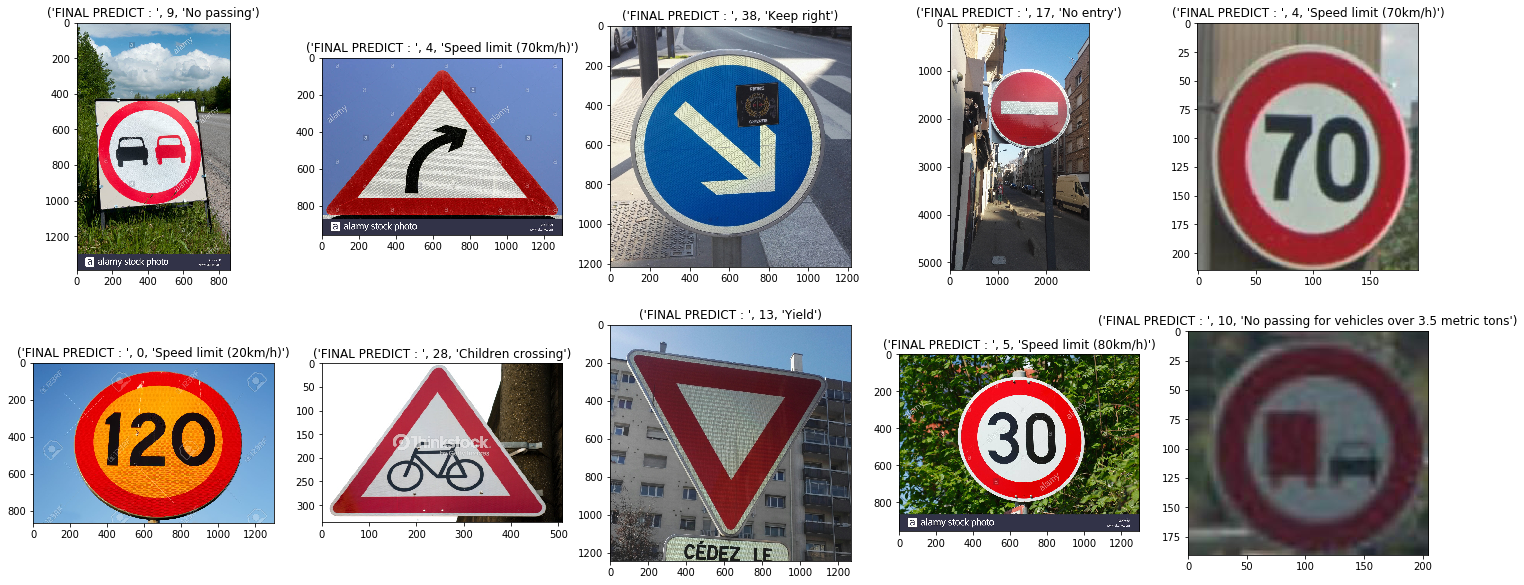

In [31]:
rows = 2
cols = 5
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(25,10)

paths = os.getcwd()+'/examples'
files = os.listdir(paths)

for num, fname in enumerate(files):
    image = mpimg.imread('./examples/'+fname)
    axs[int(num/cols)][num%cols].imshow(image)
    axs[int(num/cols)][num%cols].set_title(prediction(image), fontsize=12)

### VISUALIZATION NETWORK

INFO:tensorflow:Restoring parameters from ./model/model
False
24
False
48


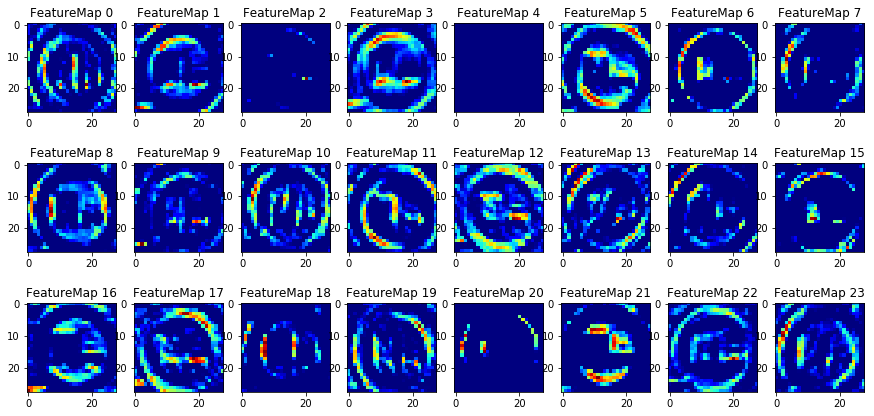

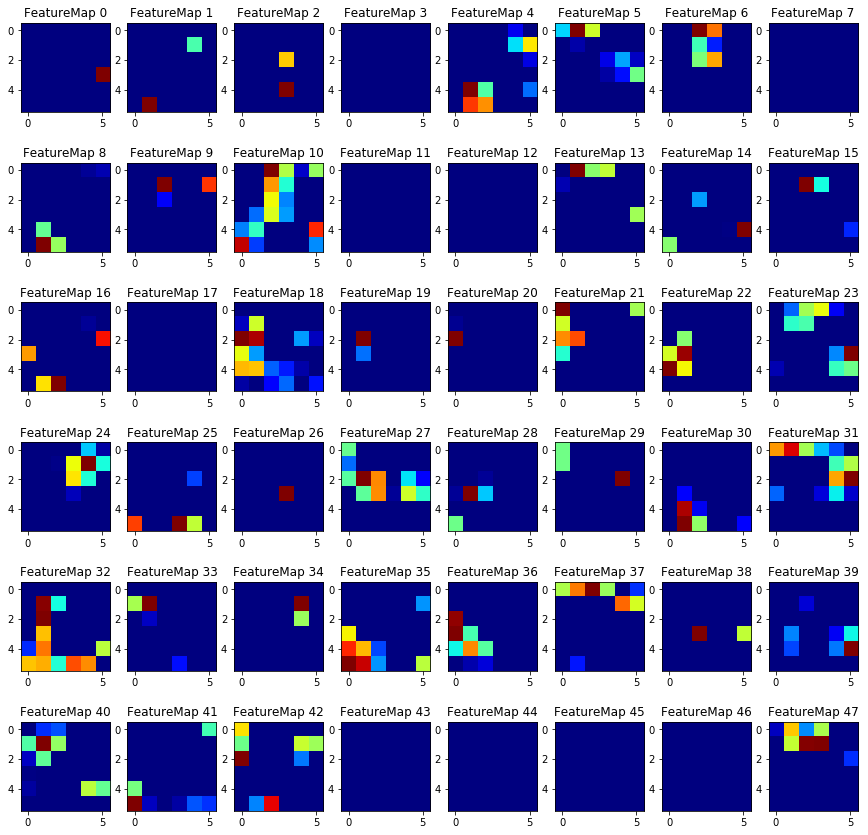

In [32]:
### Visualize network's feature maps here.

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
   
    image_input = image_input.reshape(1, 32, 32, 1)
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    print(featuremaps)
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="jet")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="jet")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="jet")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="jet")
            
            
            
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    outputFeatureMap(preprocess(None, False), conv1, plt_num=1)
    outputFeatureMap(preprocess(None, False), conv2, plt_num=2)
